# Lab 6 Report: 
## Stock Prediction AI with Encoder-Decoder RNN

### Name:

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sns

In [2]:
from IPython.display import Image # For displaying images in colab jupyter cell

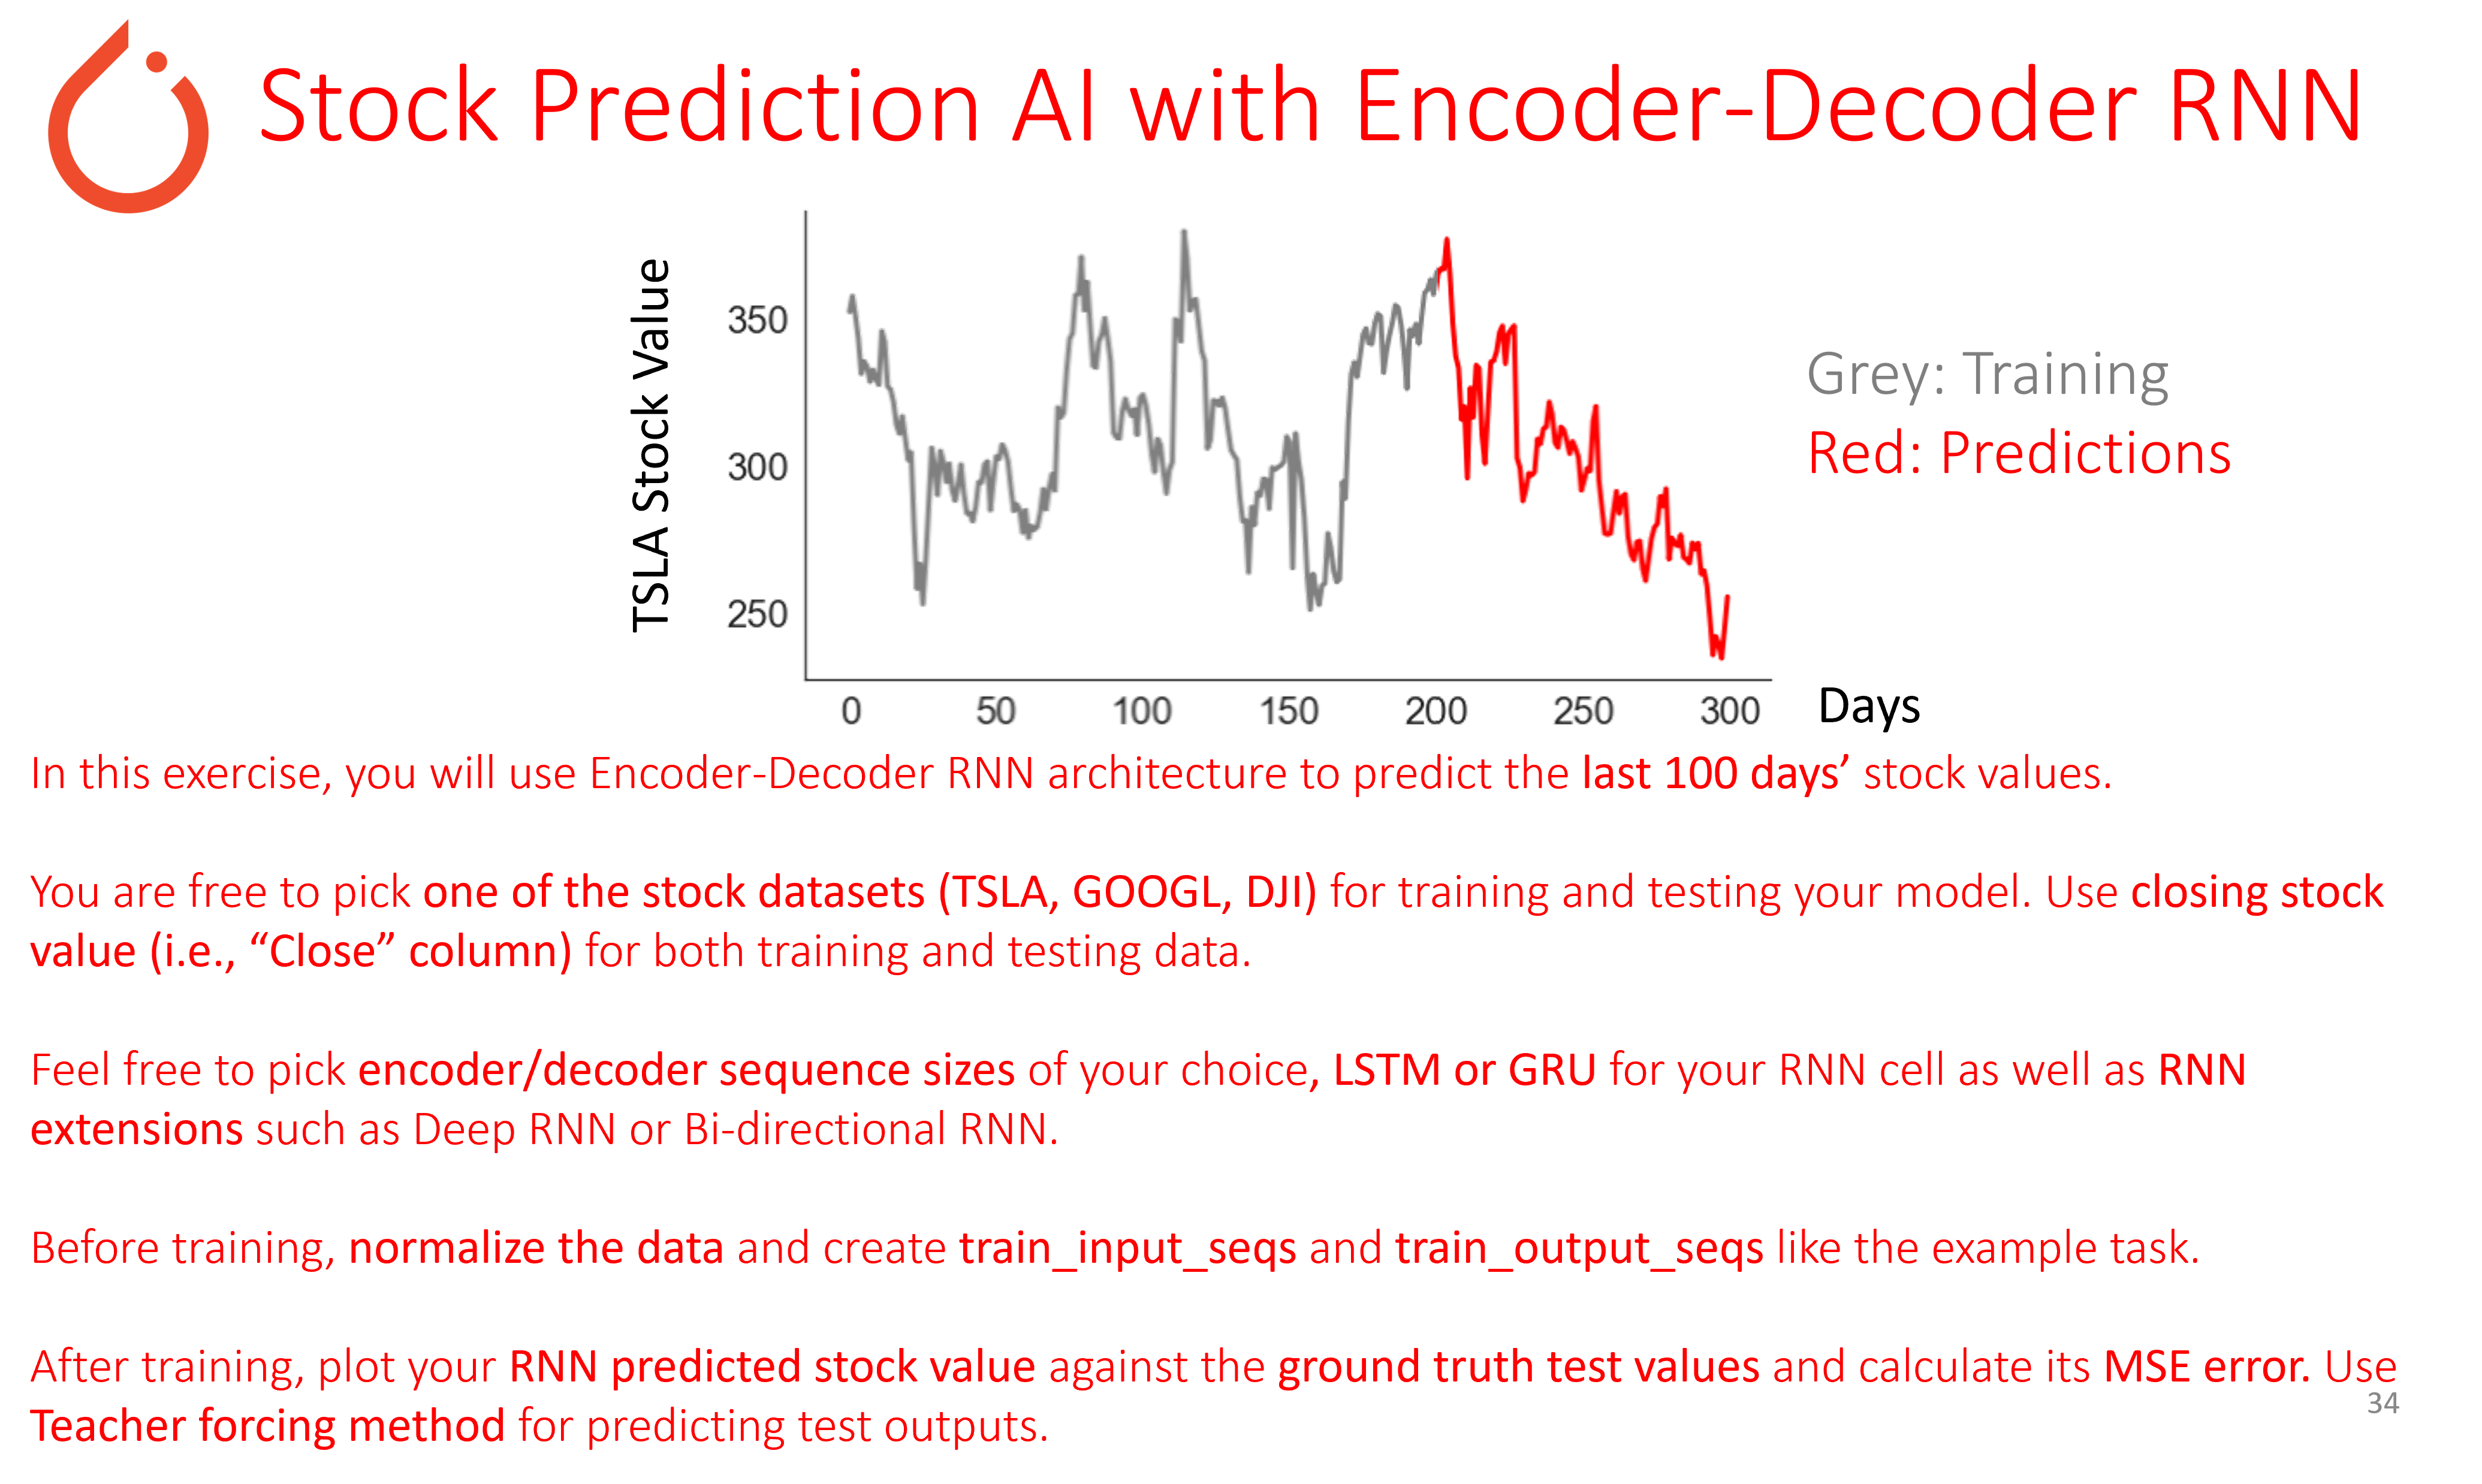

In [3]:
Image('lab6_exercise.png', width = 1000)

In [4]:
# Seaborn plot styling
sns.set(style = 'white', font_scale = 2)

## Prepare Data

In [5]:
# Load stock datasets
# Pick one of three to train your model 
# Use 'closing price' column for training and testing

tesla = pd.read_csv('TSLA.csv') 
tesla_np = tesla.to_numpy()

google = pd.read_csv('GOOGL.csv') 
google_np = google.to_numpy()

dji = pd.read_csv('DJI.csv') 
dji_np = dji.to_numpy()

# print(tesla_np.shape)
# print(tesla_np[:, 4].shape)
# print((tesla_np[:, 4]))

(2227, 7)
(2227,)
[23.889999 23.83 21.959999 ... 234.009995 244.100006 255.029999]


[[-1.32913376]
 [-1.32965451]
 [-1.34588488]
 ...
 [ 0.49456796]
 [ 0.58214254]
 [ 0.6770076 ]]
[[-1.32913376]
 [-1.32965451]
 [-1.34588488]
 ...
 [ 1.58547366]
 [ 1.6146361 ]
 [ 1.57045831]]


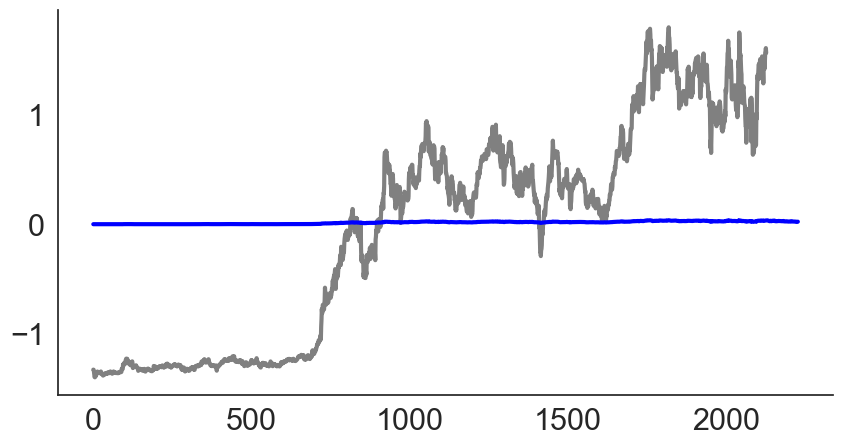

In [6]:
# Normalize your data and select training dataset (all the days except for last 100 days)

# YOUR CODE HERE
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Scale the dataset according to standard scaling
# y = preprocessing.normalize(tesla_np[:, 4].reshape(-1,1), axis=0)
y = scaler.fit_transform(tesla_np[:, 4].reshape(-1,1))
# print(y)

testing_sequence_len = 100

y_train = y[:-testing_sequence_len]
# print(y_train)

plt.figure(figsize = (10, 5))

plt.plot(y_train, linewidth = 3, color = 'grey')
plt.plot(tesla_np[:, 4]/10000., linewidth = 3, color = 'blue')
sns.despine()

In [7]:
# Define your encoder input sequence length, decoder output sequence length and testing sequence length
# Construct train_input_seqs and train_output_seqs according to 
# encoder input sequence length and decoder output sequence length similar to example task

# YOUR CODE HERE
def generate_input_output_seqs(y, encoder_inputseq_len, decoder_outputseq_len, stride = 1, num_features = 1):
  
    L = y.shape[0] # Length of y
    
    # Calculate how many input/target sequences there will be based on the parameters and stride
    num_samples = (L - encoder_inputseq_len - decoder_outputseq_len) // stride + 1
    
    # Numpy zeros arrray to contain the input/target sequences
    # Note that they should be in (num_samples, seq_len, num_features/time step) format
    train_input_seqs = np.zeros([num_samples, encoder_inputseq_len, num_features])
    train_output_seqs = np.zeros([num_samples, decoder_outputseq_len, num_features])    
    
    # Iteratively fill in train_input_seqs and train_output_seqs
    # See slide 17 of lab 7 to get an idea of how input_seqs and output_seqs look like
    for ff in np.arange(num_features):
        
        for ii in np.arange(num_samples):
            
            start_x = stride * ii
            end_x = start_x + encoder_inputseq_len
            train_input_seqs[ii, :, ff] = y[start_x:end_x, ff]

            start_y = stride * ii + encoder_inputseq_len
            end_y = start_y + decoder_outputseq_len 
            train_output_seqs[ii, :, ff] = y[start_y:end_y, ff]
    return train_input_seqs, train_output_seqs

In [8]:
encoder_inputseq_len = 5
decoder_outputseq_len = 2
# testing_sequence_len = 100 defined above

train_input_seqs, train_output_seqs = generate_input_output_seqs(y = y_train,
                                                                 encoder_inputseq_len = encoder_inputseq_len,
                                                                 decoder_outputseq_len = decoder_outputseq_len,
                                                                 stride = 1,
                                                                 num_features = 1)

In [9]:
# Make sure train_input_seqs and train_output_seqs have correct dimensions as expected
# (sample size, sequence length, # of features / timestep)

print("Encoder Training Inputs Shape: ", train_input_seqs.shape)
print("Decoder Training Outputs Shape: ", train_output_seqs.shape)

Encoder Training Inputs Shape:  (2121, 5, 1)
Decoder Training Outputs Shape:  (2121, 2, 1)


## Define Model

In [10]:
class Encoder(torch.nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        
        super(Encoder, self).__init__()

        # YOUR CODE HERE
        self.lstm = torch.nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                                  num_layers = num_layers,
                                  batch_first = True)
        
    def forward(self, input_seq, hidden_state):
        
        # YOUR CODE HERE
        out, hidden = self.lstm(input_seq, hidden_state)
        
        return out, hidden     

class Decoder(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        
        super(Decoder, self).__init__()

        # YOUR CODE HERE  
        self.lstm = torch.nn.LSTM(input_size = input_size, hidden_size = hidden_size, 
                                  num_layers = num_layers, 
                                  batch_first = True)
        self.fc_decoder = torch.nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, encoder_hidden_states):
        
        # YOUR CODE HERE
        lstm_out, hidden = self.lstm(input_seq, encoder_hidden_states)
        out = self.fc_decoder(lstm_out)
        
        return out, hidden

class Encoder_Decoder(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size, decoder_output_size, num_layers):

        super(Encoder_Decoder, self).__init__()

        # YOUR CODE HERE
        self.Encoder = Encoder(input_size = input_size, hidden_size = hidden_size, 
                               num_layers = num_layers)
        
        self.Decoder = Decoder(input_size = input_size, hidden_size = hidden_size, 
                               output_size = decoder_output_size, num_layers = num_layers)

## Define Hyperparameters

In [11]:
torch.manual_seed(2)

Encoder_Decoder_RNN = Encoder_Decoder(input_size = 1, hidden_size = 15,
                                      decoder_output_size = 1, num_layers = 1)

learning_rate = 0.002     
epochs = 50

batchsize = 5
num_features = train_output_seqs.shape[2]

loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Encoder_Decoder_RNN.parameters(), lr=learning_rate)

Encoder_Decoder_RNN

Encoder_Decoder(
  (Encoder): Encoder(
    (lstm): LSTM(1, 15, batch_first=True)
  )
  (Decoder): Decoder(
    (lstm): LSTM(1, 15, batch_first=True)
    (fc_decoder): Linear(in_features=15, out_features=1, bias=True)
  )
)

## Identify Tracked Values

In [12]:
# YOUR CODE HERE
train_loss_list = []

## Train Model

In [13]:
# Convert training data into torch tensors

train_input_seqs = torch.from_numpy(train_input_seqs).float()
train_output_seqs = torch.from_numpy(train_output_seqs).float()

# Split training data into mini-batches
# Skipping the last mini-batch since its size can be smaller than the set batchsize
train_batches_features = torch.split(train_input_seqs, batchsize)[:-1]
train_batches_targets = torch.split(train_output_seqs, batchsize)[:-1]

# Compute total number of mini-batches in training data

batch_split_num = len(train_batches_features)

In [14]:
for epoch in range(epochs): 
    
    for k in range(batch_split_num): 
        
        # initialize hidden states to Encoder
        hidden_state = None
        
        # initialize empty torch tensor array to store decoder output sequence
        decoder_output_seq = torch.zeros(batchsize, decoder_outputseq_len, num_features)
        
        # empty gradient buffer
        optimizer.zero_grad()
        
        # Feed k-th mini-batch for encoder input sequences to encoder with hidden state
        encoder_output, encoder_hidden = Encoder_Decoder_RNN.Encoder(train_batches_features[k], hidden_state)
        # Re-define the resulting encoder hidden states as input hidden states to decoder
        decoder_hidden = encoder_hidden
        
        # Initial input to decoder is last timestep feature from the encoder input sequence
        decoder_input = train_batches_features[k][:, -1, :]
        # The extracted feature is 2D so need to add additional 3rd dimension 
        # to conform to (sample size, seq_len, # of features)
        decoder_input = torch.unsqueeze(decoder_input, 2)
        
        # Populating the decoder output sequence
        for t in range(decoder_outputseq_len): # for each timestep in output sequence
            
            # Feed in the decoder_input and decoder_hidden to Decoder, get new output and hidden states
            decoder_output, decoder_hidden = Encoder_Decoder_RNN.Decoder(decoder_input, decoder_hidden)
            
            # Populate the corresponding timestep in decoder output sequence 
            decoder_output_seq[:, t, :] = torch.squeeze(decoder_output, 2)
            
            # We are using teacher forcing so using the groundtruth training target as the next input        
            decoder_input = train_batches_targets[k][:, t, :]
            
            # The extracted feature is 2D so need to add additional 3rd dimension 
            # to conform to (sample size, seq_len, # of features)
            decoder_input = torch.unsqueeze(decoder_input, 2)
        
        # Compare the predicted decoder output sequence aginast the target sequence to compute the MSE loss
        loss = loss_func(torch.squeeze(decoder_output_seq), torch.squeeze(train_batches_targets[k]))
        
        # Save the loss
        train_loss_list.append(loss.item())
        
        # Backprop
        loss.backward()
        
        # Update the RNN
        optimizer.step()
    
    print("Averaged Training Loss for Epoch ", epoch,": ", np.mean(train_loss_list[-batch_split_num:]))

Averaged Training Loss for Epoch  0 :  0.13958076246706455
Averaged Training Loss for Epoch  1 :  0.028654661903661723
Averaged Training Loss for Epoch  2 :  0.019792410969669293
Averaged Training Loss for Epoch  3 :  0.014336318453255238
Averaged Training Loss for Epoch  4 :  0.011403211880138032
Averaged Training Loss for Epoch  5 :  0.009537828840985588
Averaged Training Loss for Epoch  6 :  0.008330724943075095
Averaged Training Loss for Epoch  7 :  0.00754993998918748
Averaged Training Loss for Epoch  8 :  0.007031163652693779
Averaged Training Loss for Epoch  9 :  0.006672094192302271
Averaged Training Loss for Epoch  10 :  0.006410497761515148
Averaged Training Loss for Epoch  11 :  0.0062080499822531115
Averaged Training Loss for Epoch  12 :  0.006041216008922657
Averaged Training Loss for Epoch  13 :  0.005895725742510328
Averaged Training Loss for Epoch  14 :  0.005763276919483231
Averaged Training Loss for Epoch  15 :  0.005639574074021586
Averaged Training Loss for Epoch  1

## Visualize & Evaluate Model

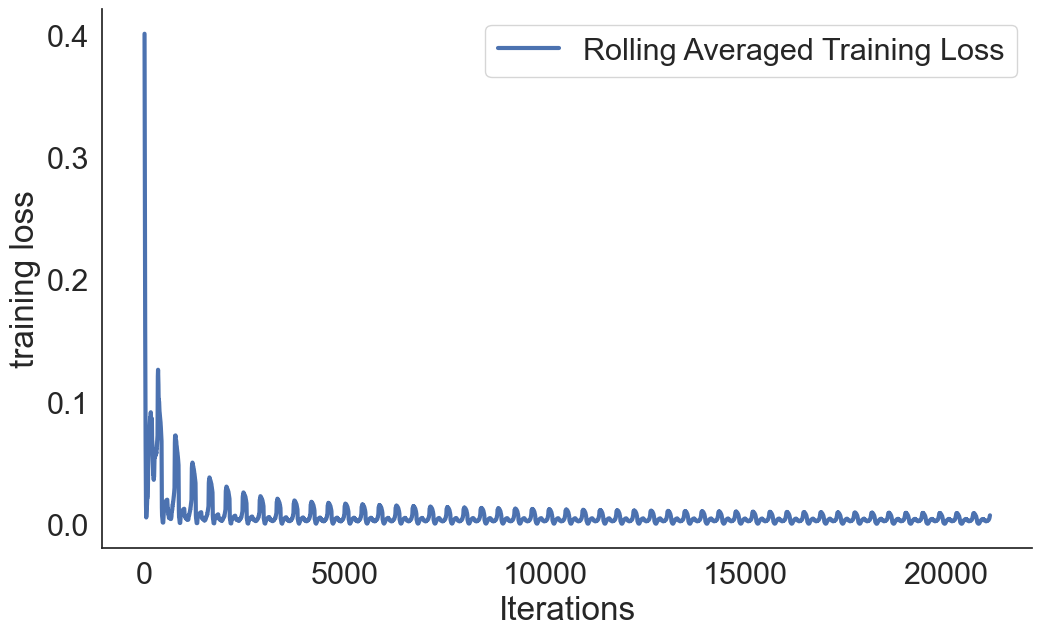

In [15]:
plt.figure(figsize = (12, 7))

plt.plot(np.convolve(train_loss_list, np.ones(100), 'valid') / 100, 
         linewidth = 3, label = 'Rolling Averaged Training Loss')
plt.ylabel("training loss")
plt.xlabel("Iterations")
plt.legend()
sns.despine()

In [16]:
# Define your testing sequence

test_input_seq = y[-testing_sequence_len:]

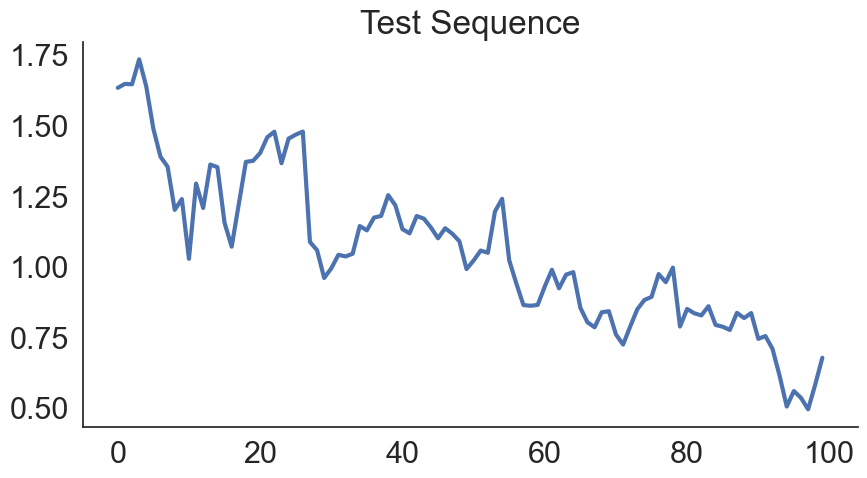

In [17]:
# We can visualize the testing sequence

plt.figure(figsize = (10, 5))
plt.plot(test_input_seq, linewidth = 3)
plt.title('Test Sequence')
sns.despine()

### Generate signal predictions for testing sequence with trained Encoder-Decoder

In [18]:
# USE TEACHER FORCING METHOD WHEN GENERATING OUTPUTS FROM DECODER
# See slide 42 of Lab 5 or Lab 5 part 2 video to recap the concept of teacher forcing method
# When generating decoder outputs, make sure each input to decoder at timestep t has the shape (1,1,1)
# i.e., num_samples = 1, sequence_len = 1, num_features = 1 

test_input_seq = torch.from_numpy(test_input_seq).float()

decoder_output_seq = torch.zeros(testing_sequence_len, num_features)

decoder_output_seq[:encoder_inputseq_len] = test_input_seq[:encoder_inputseq_len]

pred_start_ind = 0

# Activate no_grad() since we aren't performing backprop
with torch.no_grad():
    while pred_start_ind + encoder_inputseq_len + decoder_outputseq_len < testing_sequence_len:
        hidden_state = None
        input_test_seq = decoder_output_seq[pred_start_ind:pred_start_ind + encoder_inputseq_len]
        input_test_seq = torch.unsqueeze(input_test_seq, 0)

        encoder_output, encoder_hidden = Encoder_Decoder_RNN.Encoder(input_test_seq, hidden_state)
        decoder_hidden = encoder_hidden

        decoder_input = input_test_seq[:, -1, :]
        decoder_input = torch.unsqueeze(decoder_input, 2)

        for t in range(decoder_outputseq_len):
            decoder_output, decoder_hidden = Encoder_Decoder_RNN.Decoder(decoder_input, decoder_hidden)
            decoder_output_seq[pred_start_ind + encoder_inputseq_len + t] = torch.squeeze(decoder_output)
            # decoder_input = decoder_output # no teacher forcing
            decoder_input = test_input_seq[pred_start_ind + encoder_inputseq_len + t]
            # print(decoder_input.shape)
            decoder_input = torch.unsqueeze(decoder_input, 0)
            decoder_input = torch.unsqueeze(decoder_input, 2)
            # print(decoder_input[0][0])

        pred_start_ind += decoder_outputseq_len

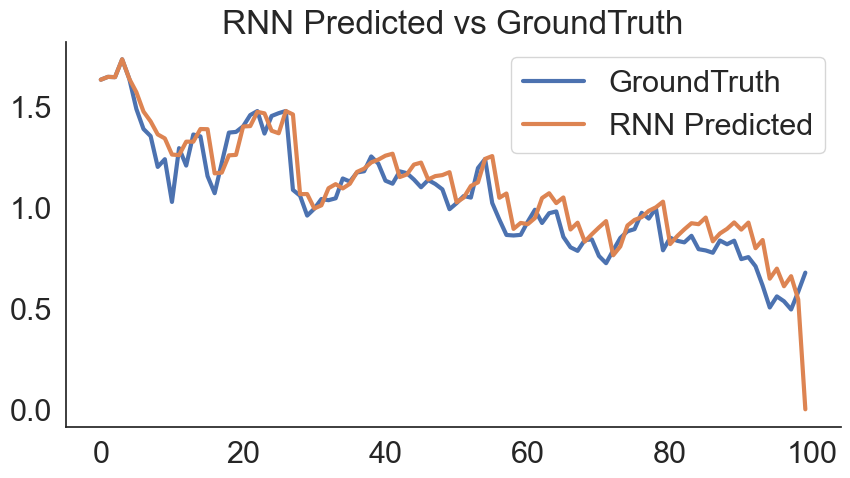

In [19]:
# Visualize predicted stock sequence vs the ground truth
# print(decoder_output_seq)
plt.figure(figsize = (10, 5))

plt.plot(test_input_seq, linewidth = 3, label = 'GroundTruth')
plt.plot(decoder_output_seq, linewidth = 3, label = 'RNN Predicted')
plt.title('RNN Predicted vs GroundTruth')
plt.legend()
sns.despine()

In [20]:
# Compute the MSE error between test_input_seq and decoder_output_seq and print the value as Test MSE Error

# YOUR CODE HERE
MSE = np.square(np.subtract(test_input_seq[:-1], decoder_output_seq[:-1])).mean()
print(MSE)

from sklearn.metrics import mean_squared_error 
print(mean_squared_error(test_input_seq[:-1], decoder_output_seq[:-1]))

tensor(0.0112)
0.011206909
